In [248]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [249]:
# humidity data
humidity = pd.read_csv("humidity.csv").dropna()
humidity["datetime"] = humidity.datetime.str[:10]
humidity_avg = humidity.groupby(["datetime"]).mean()[["Seattle"]]
humidity_avg.columns = ["humidity"]

# pressure data
pressure = pd.read_csv("pressure.csv").dropna()
pressure["datetime"] = pressure.datetime.str[:10]
pressure_avg = pressure.groupby(["datetime"]).mean()[["Seattle"]]
pressure_avg.columns = ["pressure"]

# temperature data
temperature = pd.read_csv("temperature.csv").dropna()
temperature["datetime"] = temperature.datetime.str[:10]
temperature_avg = temperature.groupby(["datetime"]).mean()[["Seattle"]]
temperature_avg.columns = ["temperature"]

# wind_direction
wind_direction = pd.read_csv("wind_direction.csv").dropna()
wind_direction["datetime"] = wind_direction.datetime.str[:10]
wind_direction_avg = wind_direction.groupby(["datetime"]).mean()[["Seattle"]]
wind_direction_avg.columns = ["wind_direction"]

# wind_speed
wind_speed = pd.read_csv("wind_speed.csv").dropna()
wind_speed["datetime"] = wind_speed.datetime.str[:10]
wind_speed_avg = wind_speed.groupby(["datetime"]).mean()[["Seattle"]]
wind_speed_avg.columns = ["wind_speed"]

# # weather description
# description = pd.read_csv("description.csv").dropna()
# description["datetime"] = description.datetime.str[:10]
# description = description.groupby(["datetime"]).mean()[["Seattle"]]
# description.columns = ["description"]

In [250]:
all_avg = humidity_avg.join(pressure_avg, how="inner").join(temperature_avg, how="inner").join(wind_direction_avg, how="inner").join(wind_speed_avg, how="inner")

In [251]:
crisis = pd.read_csv("crisis-data.csv").dropna()
crisis = crisis.sort_values(by=["Reported Date"])
num_crisis = crisis.groupby(["Reported Date"]).count()
num_crisis = num_crisis[["Reported Time"]]
num_crisis.columns = ["num_crimes"]

In [252]:
final = all_avg.join(num_crisis, how="inner")


groupings = ["(0-5)", "(6-10)", "(11-15)", "(16-20)", "(21-25)", "(26-30)", "(>30)"]


def categorize(num):
    if num <= 5:
        return groupings[0]
    elif num <= 10:
        return groupings[1]
    elif num <= 15:
        return groupings[2]
    elif num <= 20:
        return groupings[3]
    elif num <= 25:
        return groupings[4]
    elif num <= 30:
        return groupings[5]
    else:
        return groupings[6]
    
final["num_crimes"] = [categorize(x) for x in final["num_crimes"]]

In [253]:
work = final.copy()

le = preprocessing.LabelEncoder()

crimes_encoded = (le.fit_transform(work["num_crimes"]))

work["num_crimes"] = crimes_encoded


features = work.iloc[:,0:5].values
labels = work.iloc[:,-1].values


In [254]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3081761006289308


In [255]:
# KNN
kf = KFold(n_splits=10)
tot_acc = []
neighbours = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
accuracies = []

for num in neighbours:

    knn_model = KNeighborsClassifier(n_neighbors=num)
    for train_index, test_index in kf.split(features,labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        accuracies.append(metrics.accuracy_score(y_test, y_pred))
    tot_acc.append(sum(accuracies) / len(accuracies))
tot_acc

[0.2740823412698413,
 0.31034226190476194,
 0.3203042328042329,
 0.31737971230158746,
 0.3175496031746034,
 0.32027529761904766,
 0.32379180839002264,
 0.3268229166666666,
 0.32987764550264537,
 0.3315178571428571,
 0.33415178571428567]

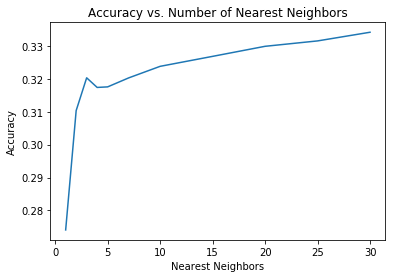

In [256]:
plt.plot(neighbours, tot_acc)
plt.ylabel('Accuracy')
plt.xlabel('Nearest Neighbors')
plt.title('Accuracy vs. Number of Nearest Neighbors')
plt.savefig('knn.png')

In [257]:
# Decision Tree n-Folds
kf = KFold(n_splits=20)
tot_acc = []
accuracies = []

model = tree.DecisionTreeClassifier()

for train_index, test_index in kf.split(features,labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
tot_acc.append(sum(accuracies) / len(accuracies))
tot_acc

[0.3967237903225806]

In [258]:
# Decision Tree all-but-one
loo = LeaveOneOut()
tot_acc = []
accuracies = []

model = tree.DecisionTreeClassifier()

for train_index, test_index in loo.split(features,labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
tot_acc.append(sum(accuracies) / len(accuracies))
tot_acc

[0.3968503937007874]

In [259]:
clf = RandomForestClassifier(n_estimators=100)

kf = KFold(n_splits=10)
tot_acc = []
accuracies = []


for train_index, test_index in kf.split(features,labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
tot_acc.append(sum(accuracies) / len(accuracies))